In [402]:
import os
import csv
import math
import random
import string
import functools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeRegressor

from keras.models import Sequential
from keras.layers import Dense

KNOTS2KMH = 1.852  # knots to km/h
KMH2KNOTS = 0.539957  # km/h to knots
MINDISTWHEEL = 2  # KM : used for the straight line above the objective
STRAIGHTLINE_SF = 4 # KM : used for the straight line to go next to the objective and another one above the objective
MINALTITUDE = 0.2  # KM : will be set with the type of terrain
MAXALTITUDE = 18  # KM : refer to M2000 max

# WARNING : Values are wrong, this is just a sketch

# FUEL_CONSUMPTION_RATE =  3 #2.5 # KG / KM for a 100 knots speed for X plane model
pd.reset_option('display.max_colwidth')


In [403]:
# average_fuel_consumption 	= 0.302 # this is highly relative, but good estimates are 36-40l/min = 28-31kg/min = 0.47-0.52kg/s -- 45l/min = 35kg/min = 0.583kg/s
class Plane:
    def __init__(self, name: str = 'TF51D', fuel_consumption_rate: float = 0.52, fuel_max: int = 501, V_OPT: int = 240, V_max: int = 485):
        self.name = name
        self.fuel_consumption_rate = fuel_consumption_rate
        self.fuel_max = fuel_max
        self.V_OPT = V_OPT  # Optimal speed in knots
        self.V_max = V_max  # Max speed in knots
        self.V_Opt_kmh = self.V_OPT * KNOTS2KMH
        self.V_max_kmh = self.V_max * KNOTS2KMH
        self.max_flight_time = round(
            self.fuel_max / self.fuel_consumption_rate)
        print("Cet avion peut voler pendant ", self.max_flight_time,
              " s, soit ", round(self.max_flight_time / 60), " min à une vitesse moyenne de ", self.V_Opt_kmh, " km/h et sa vitesse max sera de ", self.V_max_kmh, " km/h")

    def __repr__(self):
        return self.name

    def __str__(self):
        return self.name

    def get_consumption_rate(self, speed: float) -> float:
        return self.fuel_consumption_rate * speed / self.V_Opt_kmh


class Maneuver:
    # maxspeed: int, minspeed: int,
    def __init__(self, name: str, fullname: str, meanspeed: int, altitude: float, distance: float, available_mission: list = ['CAS'], efficiency: int = 50):
        if efficiency <= 100 and efficiency >= 0:
            self.efficiency = efficiency
        else:
            self.efficiency = 0
            raise Exception("Efficiency is not valid, set to 0")
        self.name = name
        self.fullname = fullname

        self.meanspeed = meanspeed  # In knots
        self.meanspeed_kmh = self.meanspeed * KNOTS2KMH
        self.maxspeed = meanspeed  # maxspeed
        self.maxspeed_kmh = meanspeed * KNOTS2KMH  # maxspeed * KNOTS2KMH
        self.minspeed = meanspeed  # minspeed
        self.minspeed_kmh = meanspeed * KNOTS2KMH  # minspeed * KNOTS2KMH

        self.altitude = altitude  # In KM
        self.minaltitude = MINALTITUDE
        self.maxaltitude = MAXALTITUDE
        self.distance = distance  # In KM
        self.available_mission = available_mission
        self.plan = self.travel_plan()

    def travelled_time(self) -> float:     
        time = sum(p['Time'] for p in self.plan)  #(lambda x : ,)   
        return time

    def fuel_consumption_rate(self, speed : float, altitude : float, plane: Plane,) -> float:
        # Kg/s according to a plane's mean consumption rate, speed and altitude
        # * 3))
        return (plane.get_consumption_rate(speed) / (altitude**2))

    def total_fuel_consumption(self, plane: Plane) -> float:
        # Kg according to the travelled time.
        total = sum(self.fuel_consumption_rate(p['Speed'], p['Altitude'], plane) * p['Time'] for p in self.plan)
        return total

    def __repr__(self):
        return self.fullname

    def __str__(self):
        return self.fullname

    def travel_plan(self) -> list :
        travel_plan = []
        plan = dict()
        plan['Speed'] = self.meanspeed_kmh
        plan['Distance'] = self.distance
        plan['Altitude'] = self.altitude
        plan['Time'] = plan['Speed'] / plan['Distance'] / 3600

        travel_plan.append(plan)
        return travel_plan

        
class Wheel(Maneuver):
    # maxspeed: int, minspeed: int,
    def __init__(self, fullname: str, meanspeed: int, altitude: float, distance: float, available_mission: list = ['CAS'], efficiency: int = 50):
        super().__init__('Wheel', fullname, meanspeed, altitude, distance,
                         available_mission, efficiency)  # maxspeed: int, minspeed: int,
        if self.distance <= 2 * MINDISTWHEEL:
            raise Exception("Not enough distance, at least ",
                            MINDISTWHEEL * 2, " km for a nicely done wheel")


    def travel_plan(self) -> list:
        travel_plan = []
        first = dict()
        first['Speed'] = self.meanspeed_kmh
        first['Distance'] = MINDISTWHEEL
        first['Altitude'] = self.altitude
        first['Time'] = MINDISTWHEEL / (self.meanspeed_kmh / 3600)
        travel_plan.append(first)

        second = dict()
        second['Speed'] = self.minspeed_kmh
        second['Distance'] = 0.5
        second['Altitude'] = self.altitude
        second['Time'] = 0.5 / (self.minspeed_kmh / 3600)
        travel_plan.append(second)

        third = dict()
        third['Speed'] = self.maxspeed_kmh
        third['Distance'] = self.distance - MINDISTWHEEL - 0.5
        third['Altitude'] = self.altitude
        third['Time'] = third['Distance'] / (third['Speed'] / 3600)
        travel_plan.append(third)
        return travel_plan


class ShowOfForce(Maneuver):
    # maxspeed: int, minspeed: int,
    def __init__(self, fullname: str, meanspeed: int, altitude: float, distance: float, available_mission: list = ['CAS'], efficiency: int = 50):
        super().__init__('ShowOfForce', fullname, meanspeed,
                         altitude, distance,
                         available_mission,
                         efficiency)  # maxspeed: int, minspeed: int,

    

    def travel_plan(self) -> list:
        travel_plan = []
        first = dict()
        first['Speed'] = self.meanspeed_kmh
        first['Distance'] = STRAIGHTLINE_SF
        first['Altitude'] = self.altitude
        first['Time'] = STRAIGHTLINE_SF / (self.meanspeed_kmh / 3600)
        travel_plan.append(first)

        second = dict()
        second['Speed'] = self.minspeed_kmh
        second['Distance'] = 2
        second['Altitude'] = MAXALTITUDE
        second['Time'] = 2 / (self.minspeed_kmh / 3600)
        travel_plan.append(second)

        third = dict()
        third['Speed'] = self.maxspeed_kmh
        third['Distance'] = self.distance - STRAIGHTLINE_SF - 2
        third['Altitude'] = self.altitude
        third['Time'] = third['Distance'] / (third['Speed'] / 3600)
        travel_plan.append(third)

        return travel_plan

In [404]:

list_maneuvers = [
    Wheel('FastFullWheel', 350, 1, 10, ['CAS', 'SCAR'], 100),
    # Maneuver('FastQuarterWheel', 350, 1, 2, ['CAS', 'SCAR'], 50),
    Wheel('FastHalfWheel', 350, 1, 6, ['CAS', 'SCAR'], 75),
    Wheel('NormalFullWheel', 240, 1, 10, ['CAS', 'SCAR'], 85),
    # Maneuver('NormalQuarterWheel', 240, 1, 2, ['CAS', 'SCAR'], 40),
    Wheel('NormalHalfWheel', 240, 1, 6, ['CAS', 'SCAR'], 75),
    Wheel('FullLowWheel', 240, 0.5, 10, ['CAS', 'SCAR'], 75),
    # Maneuver('QuarterLowWheel', 240, 0.5, 2, ['CAS', 'SCAR'], 30),
    Wheel('HalfLowWheel', 240, 0.5, 6, ['CAS', 'SCAR'], 50),
    Wheel('LargeFullWheel', 350, 1, 14, ['CAS', 'SCAR'], 95),
    # Maneuver('NormalFullWheel',250, 1, 8, ['CAS', 'SCAR']), Maneuver('NormalQuarterWheel', 250, 1, 4, ['CAS', 'SCAR']),
    # Maneuver('NormalHalfWheel', 250, 1, 4, ['CAS', 'SCAR']), Maneuver('NormalLowFullWheel',250, 0.5, 8, ['CAS', 'SCAR']),
    # Maneuver('NormalLowQuarterWheel', 250, 0.5, 4, ['CAS', 'SCAR']), Maneuver('NormalLowHalfWheel', 250, 0.5, 4, ['CAS', 'SCAR']),
    Wheel('SlowFullWheel', 180, 1, 10, ['CAS', 'SCAR'], 65),
    Wheel('SlowHalfWheel', 180, 1, 6, ['CAS', 'SCAR'], 50),
    # Maneuver('SlowQuarterWheel', 180, 1, 2, ['CAS', 'SCAR'], 25),
    Wheel('SlowLowFullWheel', 180, 1, 10, ['CAS', 'SCAR'], 40),
    Wheel('SlowLowHalfWheel', 180, 1, 6, ['CAS', 'SCAR'], 30),
    # Maneuver('SlowLowQuarterWheel', 180, 1, 2, ['CAS', 'SCAR'], 20),
    Wheel('HighFullWheel', 240, 1.5, 10, ['CAS', 'SCAR'], 90),
    Wheel('HighHalfWheel', 240, 1.5, 6, ['CAS', 'SCAR'], 75),
    # Maneuver('HighQuarterWheel', 240, 1.5, 2, ['CAS', 'SCAR'], 50),
    ShowOfForce('ClassicShowOfForce',
                500, 0.3, 10, ['SCAR'], 100),
]


In [405]:
dic_maneuvers = dict()

for i in range(len(list_maneuvers)):
    dic_maneuvers[i] = list_maneuvers[i]


In [406]:
print(dic_maneuvers)


{0: FastFullWheel, 1: FastHalfWheel, 2: NormalFullWheel, 3: NormalHalfWheel, 4: FullLowWheel, 5: HalfLowWheel, 6: LargeFullWheel, 7: SlowFullWheel, 8: SlowHalfWheel, 9: SlowLowFullWheel, 10: SlowLowHalfWheel, 11: HighFullWheel, 12: HighHalfWheel, 13: ClassicShowOfForce}


In [407]:
TF51D = Plane()
M2000 = Plane('M2000', 2, 3200, 532, 2340 * KMH2KNOTS)
plane_list = [TF51D, M2000]


Cet avion peut voler pendant  963  s, soit  16  min à une vitesse moyenne de  444.48  km/h et sa vitesse max sera de  898.22  km/h
Cet avion peut voler pendant  1600  s, soit  27  min à une vitesse moyenne de  985.264  km/h et sa vitesse max sera de  2340.00085176  km/h


In [408]:
print("Voila le coût en fuel des manoeuvres : ")
for plane in plane_list:
    print("Plane : ", plane)
    for man in list_maneuvers:
        print(man.total_fuel_consumption(plane),
              " kg for this maneuver | ", man.travelled_time(), " seconds for this maneuver, so ", math.floor(man.travelled_time() / 60), " min ", round(man.travelled_time() % 60, 2), " seconds")


Voila le coût en fuel des manoeuvres : 
Plane :  TF51D
42.11663066954643  kg for this maneuver |  55.53841406973156  seconds for this maneuver, so  0  min  55.54  seconds
25.269978401727858  kg for this maneuver |  33.323048441838935  seconds for this maneuver, so  0  min  33.32  seconds
42.11663066954643  kg for this maneuver |  80.99352051835852  seconds for this maneuver, so  1  min  20.99  seconds
25.26997840172786  kg for this maneuver |  48.59611231101512  seconds for this maneuver, so  0  min  48.6  seconds
168.46652267818573  kg for this maneuver |  80.99352051835852  seconds for this maneuver, so  1  min  20.99  seconds
101.07991360691145  kg for this maneuver |  48.59611231101512  seconds for this maneuver, so  0  min  48.6  seconds
58.963282937365  kg for this maneuver |  77.75377969762418  seconds for this maneuver, so  1  min  17.75  seconds
42.11663066954644  kg for this maneuver |  107.9913606911447  seconds for this maneuver, so  1  min  47.99  seconds
25.26997840172786

In [409]:
import itertools


def get_all_combinations(d: dict) -> dict:
    keys, values = zip(*d.items())
    ret = [{'metadata': dict(zip(keys, v))}
           for v in itertools.product(*values)]
    return ret


param_list = {
    'Plane': plane_list,
    'GoalDistance': [0, 10, 15, 20, 30],
    'BingoDistance': [0, 10, 15, 20, 30],
    'Fuel': [300, 400, 400, 450, 500, 550],
    'MaxSpeedOP': [250, 300, 350, 400],
    # Start with just 2 states : good (sunny, no clouds) and bad (cloudy or rainy)
    'Meteo': ["Bad", "Good"],
    'MissionType': ['SCAR'],  # 'CAS',
    # Add ennemies number afterwards, weaponry
    'Strength': ['Weak', 'Equal', 'Strong'],
    # '' : [90,0,50]
}

all_combinations_not_filtered = get_all_combinations(param_list)
all_combinations = []
for c in all_combinations_not_filtered:
    data = c['metadata']

    plane = data['Plane']
    if plane.name == 'M2000':
        data['Fuel'] *= 6
    # Check if the data corresponds to the plane caracteristics
    if plane.fuel_max >= data['Fuel'] and plane.V_max >= data['MaxSpeedOP']:
        all_combinations.append(data)


In [410]:
print(len(all_combinations))
print(len(all_combinations_not_filtered))


6000
7200


In [411]:
for c in all_combinations:
    plane = c['Plane']
    fcr = plane.fuel_consumption_rate
    speed = c['MaxSpeedOP'] * KNOTS2KMH
    c['FuelRemaining'] = c['Fuel'] - (fcr * (c['GoalDistance'] / speed) * 3600) - (
        fcr * (c['BingoDistance'] / speed) * 3600)
    # c['BaseFuelRemaining'] = c['FuelRemaining']


In [412]:
def choose_randomly(maneuvers_for_c, c) -> list:
    percent = math.ceil(random.random() * 100)
    # percent = math.ceil(random.gauss(50,(50-5)/3))
    if percent < 0:
        percent += 100
    elif percent > 100:
        percent -= 100
    max_speed = c['MaxSpeedOP']
    new_maneuvers = []
    new_maneuvers = filter(
        lambda m: dic_maneuvers[m].meanspeed <= max_speed, maneuvers_for_c)
    if c['Strength'] == 'Weak' or c['Strength'] == 'Equal':
        if percent <= 95:
            new_maneuvers = filter(
                lambda m: dic_maneuvers[m].meanspeed >= 200, new_maneuvers)
        else:
            new_maneuvers = filter(
                lambda m: dic_maneuvers[m].meanspeed < 200, new_maneuvers)
    elif c['Strength'] == 'Strong':
        if percent <= 95:
            new_maneuvers = filter(
                lambda m: dic_maneuvers[m].meanspeed < 200, new_maneuvers)
        else:
            new_maneuvers = filter(
                lambda m: dic_maneuvers[m].meanspeed >= 200, new_maneuvers)

    if c['Meteo'] == "Bad":
        if percent <= 95:
            new_maneuvers = filter(
                lambda m: dic_maneuvers[m].altitude < 1, new_maneuvers)
        else:
            new_maneuvers = filter(
                lambda m: dic_maneuvers[m].altitude >= 1, new_maneuvers)
    else:
        if percent <= 95:
            new_maneuvers = filter(
                lambda m: dic_maneuvers[m].altitude >= 1, new_maneuvers)
        else:
            new_maneuvers = filter(
                lambda m: dic_maneuvers[m].altitude < 1, new_maneuvers)
    return list(new_maneuvers)


In [413]:
def select_maneuvers(maneuvers_for_c, c):
    selected = []
    minCost = min(dic_maneuvers[man].total_fuel_consumption(
        c['Plane']) for man in maneuvers_for_c)
    minEfficiency = min(
        dic_maneuvers[man].efficiency for man in maneuvers_for_c)
    efficiency = 90
    # and len(selected) < 4:
    # print(c['FuelRemaining'])
    while c['FuelRemaining'] >= minCost and efficiency >= minEfficiency and len(selected) < 5:
        maneuvers_with_eff = list(filter(
            lambda man: dic_maneuvers[man].efficiency >= efficiency, maneuvers_for_c))
        if len(maneuvers_with_eff) != 0:
            rand = random.randint(0, len(maneuvers_with_eff)-1)
            man = dic_maneuvers[maneuvers_with_eff[rand]]
            if (c['FuelRemaining'] - man.total_fuel_consumption(c['Plane'])) >= 0:
                c['FuelRemaining'] -= man.total_fuel_consumption(c['Plane'])
                selected.append(maneuvers_with_eff[rand])
            else:
                efficiency -= 5
        else:
            efficiency -= 5
    return selected


In [414]:
indexed_maneuvers = list_maneuvers.copy()

p = True
combinations = all_combinations.copy()
count = 0
all_maneuvers_for_c = []
for c in combinations:
    maneuvers_for_c = list(filter(
        lambda m: c['MissionType'] in dic_maneuvers[m].available_mission, dic_maneuvers))
    maneuvers_for_c = list(filter(lambda m: dic_maneuvers[m].total_fuel_consumption(
        c['Plane']) < c['FuelRemaining'], maneuvers_for_c))
    maneuvers_for_c = choose_randomly(maneuvers_for_c, c)
    all_maneuvers_for_c.append(maneuvers_for_c)


In [415]:
final_combinations = combinations.copy()
for c, maneuvers_for_c in zip(final_combinations, all_maneuvers_for_c):
    if len(maneuvers_for_c) > 0:
        maneuvers = select_maneuvers(maneuvers_for_c, c)
        if maneuvers != None or len(maneuvers) > 0:
            c['Maneuvers'] = list(maneuvers)
            c['TimeOfMission'] = sum(
                dic_maneuvers[m].travelled_time() for m in c['Maneuvers'])


In [416]:
# print(impossible_combinations)
final_combinations_plane = [
    c for c in final_combinations if c.get("Maneuvers")]
# print(len(final_combinations), len(final_combinations_plane))
# for c in final_combinations_plane:
#     # c['Maneuvers'] = [c.__dict__ for c in c['Maneuvers']]
#     # c['Plane'] = c['Plane']

final_combinations_maneuvers = final_combinations_plane.copy()
# final_combinations_maneuvers = final_combinations.copy()
list_maneuvers = []

for c in final_combinations_maneuvers:
    list_maneuvers.append(c['Maneuvers'])

print(len(list_maneuvers))
first_tuple_list = []
for lst in list_maneuvers:
    first_tuple_list.append(tuple(lst))
print("Done")
set_man = set(first_tuple_list)
new_dict = dict()

for i in range(len(set_man)):
    new_dict[set_man.pop()] = i
print(len(new_dict))


4946
Done
285


In [417]:
# print(dic_maneuvers.get(i))

for c in final_combinations_maneuvers:
    c['Maneuvers'] = new_dict.get(tuple(c['Maneuvers']))
df = pd.DataFrame(final_combinations_maneuvers)


In [418]:

df.sample(10)


,Plane,GoalDistance,BingoDistance,Fuel,MaxSpeedOP,Meteo,MissionType,Strength,FuelRemaining,Maneuvers,TimeOfMission
4620,M2000,30,10,2700,350,Bad,SCAR,Strong,1953.641664,217,398.488121
4292,M2000,20,20,2400,250,Good,SCAR,Strong,1412.585459,97,539.956803
993,TF51D,15,0,300,250,Bad,SCAR,Weak,70.885529,198,80.993521
201,TF51D,0,15,300,250,Good,SCAR,Weak,145.759539,34,404.967603
4297,M2000,20,20,2400,300,Good,SCAR,Strong,420.104256,182,404.967603
3533,M2000,15,0,2700,400,Good,SCAR,Weak,2281.391383,247,376.272755
490,TF51D,0,30,500,400,Bad,SCAR,Weak,87.257019,234,161.987041
3200,M2000,10,15,2400,400,Good,SCAR,Strong,1791.635135,97,539.956803
707,TF51D,10,15,300,350,Good,SCAR,Equal,70.564641,138,376.272755
587,TF51D,10,0,500,350,Bad,SCAR,Weak,134.186979,234,161.987041


In [419]:

df.describe()


,GoalDistance,BingoDistance,Fuel,MaxSpeedOP,FuelRemaining,Maneuvers,TimeOfMission
count,4946.000000,4946.000000,4946.000000,4946.000000,4946.000000,4946.000000,4946.000000
mean,14.993934,14.961585,1436.534573,325.010109,731.335242,128.923575,364.567692
std,9.994941,9.993352,1063.832114,55.871168,793.532640,75.149026,137.730279
min,0.000000,0.000000,300.000000,250.000000,0.236553,0.000000,48.596112
25%,10.000000,10.000000,400.000000,300.000000,88.336933,37.000000,325.362542
50%,15.000000,15.000000,1800.000000,300.000000,252.851486,101.000000,404.967603
75%,20.000000,20.000000,2400.000000,350.000000,1378.427711,183.750000,404.967603
max,30.000000,30.000000,3000.000000,400.000000,2837.606976,284.000000,539.956803


In [420]:
pd.set_option('display.max_colwidth', None)
df.sample(1).get("Maneuvers")
pd.reset_option('display.max_colwidth')


In [421]:


df = pd.get_dummies(df, columns=["Plane", "Meteo", "MissionType", "Strength"])
df.sample(10)
# data_MissionType = pd.DataFrame(ohe.fit_transform(data_meteo[["MissionType"]]))
# data_Strength = pd.DataFrame(ohe.fit_transform(data_MissionType[["Strength"]]))
# data_Strength


,GoalDistance,BingoDistance,Fuel,MaxSpeedOP,FuelRemaining,Maneuvers,TimeOfMission,Plane_TF51D,Plane_M2000,Meteo_Bad,Meteo_Good,MissionType_SCAR,Strength_Equal,Strength_Strong,Strength_Weak
4,0,0,300,250,89.416847,97,539.956803,1,0,0,1,1,0,1,0
123,0,10,400,300,29.373650,234,161.987041,1,0,1,0,1,1,0,0
4242,20,15,3000,350,1149.693889,182,404.967603,0,1,1,0,1,1,0,0
3153,10,10,3000,350,1316.309131,182,404.967603,0,1,1,0,1,1,0,0
1845,20,20,400,400,29.373650,37,129.589633,1,0,1,0,1,0,0,1
4775,30,20,2400,300,1589.658812,34,404.967603,0,1,0,1,1,0,0,1
4463,30,0,1800,400,1195.004791,50,350.817649,0,1,0,1,1,0,0,1
4816,30,20,2700,300,1889.658812,34,404.967603,0,1,0,1,1,1,0,0
4009,20,0,2400,400,1793.137271,55,369.793274,0,1,0,1,1,1,0,0
1544,20,0,400,350,225.249409,3,379.512496,1,0,0,1,1,1,0,0


In [422]:
df_first = df.copy()
X_train, X_test, y_train, y_test = train_test_split(df_first.drop(
    "TimeOfMission", axis=1), df_first["TimeOfMission"], test_size=0.15)
# X_train, X_test, y_train, y_test = train_test_split( df.drop("Maneuvers", axis=1), df["Maneuvers"], test_size=0.30)
models = [Lasso(), KNeighborsRegressor(), RandomForestRegressor(),
          GradientBoostingRegressor()]

once = False
for model in models:

    # Model is trained with the corrupted / imputed data
    model.fit(X_train, y_train)

    # Model performance is evaluated against the original test dataset
    y_pred = model.predict(X_test)
    # y_pred = [round(y) for y in y_pred]
    score = r2_score(y_test, y_pred)
    if not once:
        for t, p in zip(y_test, y_pred):
            print(t, p)
        once = True
    print(model, score)


161.98704103671705 171.64420597573195
242.98056155507555 286.63572271649775
80.99352051835852 124.92495821610527
372.5701943844492 691.4751553318913
129.58963282937364 223.14094225932973
404.9676025917926 407.1591630066992
340.6356062943536 372.67634440375207
401.7278617710583 419.03006600702093
404.9676025917926 412.35184308231413
404.9676025917926 385.7703089112259
539.9568034557235 531.198187335359
539.9568034557235 540.7949706959835
347.57790805307 417.2230467896018
404.9676025917926 404.6858616952636
404.9676025917926 410.7912495630717
161.98704103671705 161.82246759609995
404.9676025917926 394.6744664451106
325.3625424251774 421.719275619468
80.99352051835852 132.65915191287087
161.98704103671705 190.85968269116114
539.9568034557235 500.65902798912254
80.99352051835852 157.8429914505916
347.57790805307 418.49314616073775
328.60228324591174 439.34064608711975
404.9676025917926 411.07640865546153
539.9568034557235 550.809845553255
129.58963282937364 239.29655215028788
350.817648873

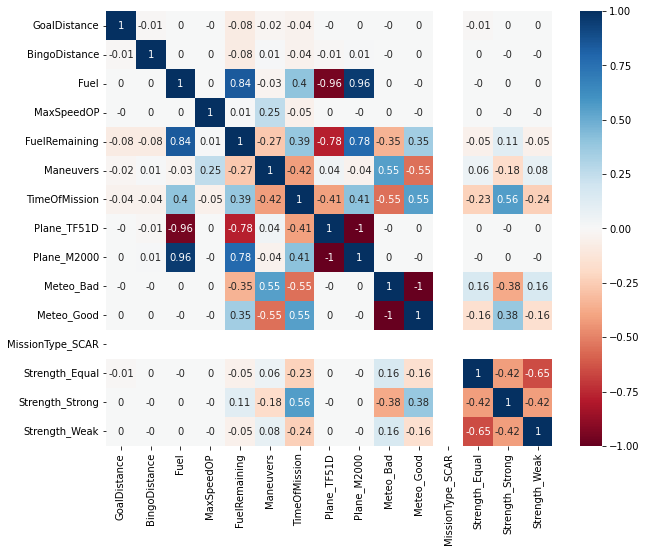

In [423]:
matrice_corr = df_first.corr().round(2)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(data=matrice_corr, cmap='RdBu', annot=True)

plt.show()


In [424]:

df_second = df.copy()
# , df_second["Maneuvers"],]
X_train, X_test, y_train, y_test = train_test_split(df_second.drop(
    ["TimeOfMission", "Maneuvers", "FuelRemaining"], axis=1), df_second["Maneuvers"], test_size=0.30)
# X_train, X_test, y_train, y_test = train_test_split( df.drop("Maneuvers", axis=1), df["Maneuvers"], test_size=0.30)
models = [Lasso(), KNeighborsRegressor(), RandomForestRegressor(
    n_estimators=100), GradientBoostingRegressor(), DecisionTreeRegressor(max_depth=5)]

print(X_train.columns)


Index(['GoalDistance', 'BingoDistance', 'Fuel', 'MaxSpeedOP', 'Plane_TF51D',
       'Plane_M2000', 'Meteo_Bad', 'Meteo_Good', 'MissionType_SCAR',
       'Strength_Equal', 'Strength_Strong', 'Strength_Weak'],
      dtype='object')


In [425]:

for model in models:
    # Model is trained with the corrupted / imputed data
    model.fit(X_train, y_train)

once = False
dim = X_train.shape[1]
epochs = 50
activation_names = ["relu", "sigmoid", "tanh"]
# for activation in activation_names :
#     model = Sequential()
#     #On pourrait essayer de rajouter plusieurs paramètres de modèles différents notamment en rajoutant des couches supplémentaires ou en utilisant un nombre de neurones cachés différent. Nous allons nous contenter ici de seulement changer la fonction d'activation.
#     model.add(Dense(150, input_dim= dim, activation=activation))
#     #On peut essayer d'ajouter une couche intermédiaire, mais la performance ne sera pas assez intéressante
#     #model.add(Dense(300, activation=name))
#     model.add(Dense(150, activation=activation))

#     # Vu que l'on utilise une régression pour un prix, on utilise une fonction d'activation linéaire pour la sortie
#     model.add(Dense(1, activation='linear'))
#     model.compile(loss='mean_squared_error', optimizer='adam')

#     #visualize_model(X_train, X_test, y_train, y_test, model, show_pred_vs_y_test=True)
#     model.fit(X_train, y_train,epochs=epochs, verbose = 0)

#     models.append(model)
scores = []
for model in models:

    # Model performance is evaluated against the original test dataset
    y_pred = model.predict(X_test)
    # y_pred = [round(y) for y in y_pred]
    scores.append(r2_score(y_test, y_pred))
    if not once:
        for t, p, x in zip(y_test, y_pred, X_test.values):
            print(t, p, x)
        once = True


182 199.5356860710972 [  15   30 2400  400    0    1    1    0    1    1    0    0]
18 97.59852694027434 [  30   10 2400  350    0    1    0    1    1    1    0    0]
97 100.18585111618319 [  20   20 2400  350    0    1    0    1    1    0    1    0]
198 166.88664177323628 [ 30   0 400 300   1   0   1   0   1   0   0   1]
189 163.85179237408502 [  30   15 1800  300    0    1    1    0    1    1    0    0]
182 198.66906099636205 [   0    0 3000  400    0    1    1    0    1    1    0    0]
182 198.29793759370935 [  20    0 1800  400    0    1    1    0    1    1    0    0]
37 188.82850381263168 [ 10  20 400 350   1   0   1   0   1   0   0   1]
182 146.26477658896968 [  20    0 2400  250    0    1    1    0    1    1    0    0]
234 155.87067301565716 [  0   0 400 250   1   0   1   0   1   0   0   1]
234 169.32967262064457 [ 20  10 450 300   1   0   1   0   1   1   0   0]
37 201.6172608850431 [ 30  20 450 400   1   0   1   0   1   1   0   0]
182 164.753554481453 [  10   10 2700  300    0 

In [426]:
for model, score in zip(models, scores):
    print(model, score)


Lasso() 0.36639572941664533
KNeighborsRegressor() 0.044786057854416694
RandomForestRegressor() 0.5054881322892203
GradientBoostingRegressor() 0.5662582425677382
DecisionTreeRegressor(max_depth=5) 0.5634141607996561


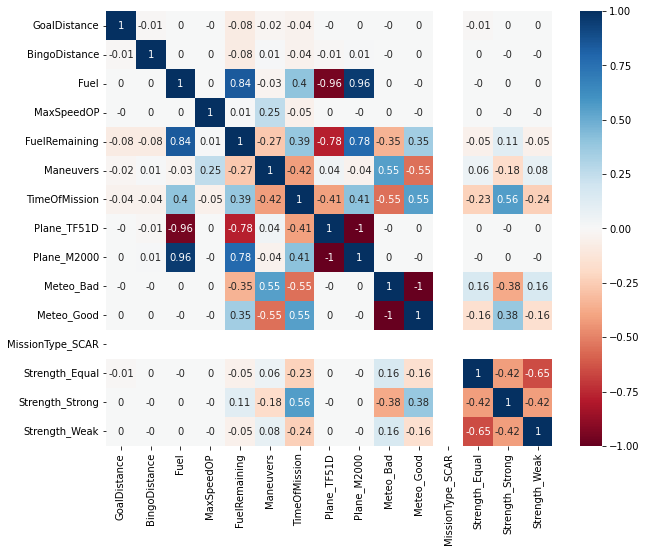

In [427]:

matrice_corr = df_second.corr().round(2)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(data=matrice_corr, cmap='RdBu', annot=True)

plt.show()


In [428]:
# Export as dot file
# export_graphviz(models[4], out_file='tree.dot',
#                 feature_names=df_second.drop(
#                     ["TimeOfMission", "FuelRemaining", "Maneuvers"], axis=1).columns,
#                 class_names="TimeOfMission",
#                 rounded=True, proportion=False,
#                 precision=6, filled=True)
# os.system('dot -Tpng tree.dot -o tree.png')
# Display in jupyter notebook


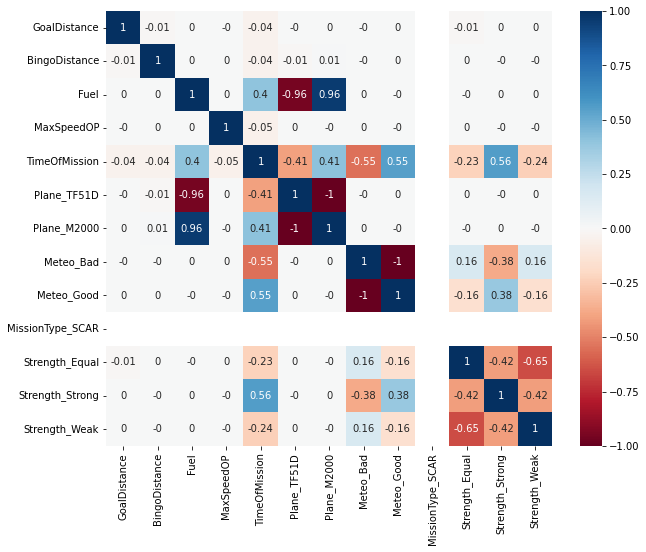

In [429]:

matrice_corr = df_second.drop(
    ["Maneuvers", "FuelRemaining"], axis=1).corr().round(2)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(data=matrice_corr, cmap='RdBu', annot=True)

plt.show()
